In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, roc_auc_score, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

In [31]:
df = pd.read_csv('process_dataset.csv')

In [32]:
X = df.drop('remainder__satisfaction_encoded', axis=1)
y = df['remainder__satisfaction_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [33]:
print("=== DEFAULT SVM ===")
default_svm = SVC(kernel='rbf', probability=True, random_state=42)
default_svm.fit(X_train_scaled, y_train)

y_pred_default = default_svm.predict(X_test_scaled)
y_proba_default = default_svm.predict_proba(X_test_scaled)[:, 1]

# Metrics
metrics_default = [
    accuracy_score(y_test, y_pred_default),
    f1_score(y_test, y_pred_default),
    precision_score(y_test, y_pred_default),
    recall_score(y_test, y_pred_default),
    roc_auc_score(y_test, y_proba_default)
]

=== DEFAULT SVM ===


In [27]:
# Confusion matrix
cm_default = confusion_matrix(y_test, y_pred_default)
sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Default SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

MODEL 2: MANUAL PARAMETER TUNING (Linear Kernel Fast)

Manual Tuning Results (LinearSVC):
    Parameters  Accuracy  F1 Score  Precision    Recall       AUC
0   {'C': 0.1}  0.851921   0.83583   0.845514  0.826365  0.911935
1   {'C': 1.0}  0.851921   0.83583   0.845514  0.826365  0.911933
2  {'C': 10.0}  0.851921   0.83583   0.845514  0.826365  0.911933

 Best Manual Parameters: {'C': 0.1}


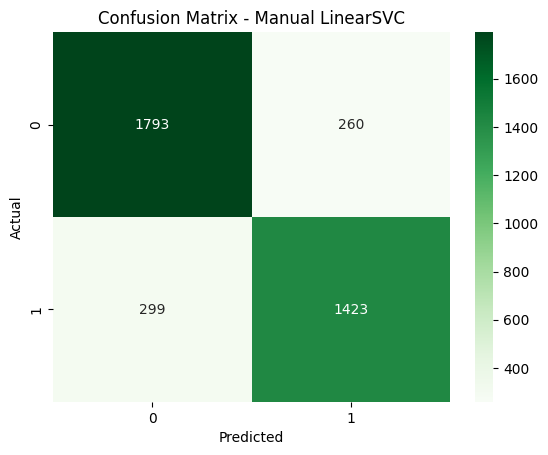

In [34]:
# Confusion Matrix for Best Manual
best_manual_model = LinearSVC(max_iter=5000, **best_manual['Parameters'], random_state=42)
best_manual_model.fit(X_train_scaled, y_train)
y_pred_manual = best_manual_model.predict(X_test_scaled)
y_scores_manual = best_manual_model.decision_function(X_test_scaled)
cm_manual = confusion_matrix(y_test, y_pred_manual)
sns.heatmap(cm_manual, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Manual LinearSVC")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [35]:
# 3. Manual Parameter Tuning (LinearSVC)
# -------------------------
print("\n=== MANUAL TUNING: LinearSVC ===")

manual_params = [{'C': 0.1}, {'C': 1.0}, {'C': 10.0}]
results_manual = []

for params in manual_params:
    model = LinearSVC(max_iter=5000, **params, random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_scores = model.decision_function(X_test_scaled)

    results_manual.append({
        'Parameters': params,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_scores)
    })

manual_df = pd.DataFrame(results_manual)
print("\nManual Tuning Results:")
print(manual_df)



=== MANUAL TUNING: LinearSVC ===

Manual Tuning Results:
    Parameters  Accuracy  F1 Score  Precision    Recall       AUC
0   {'C': 0.1}  0.851921   0.83583   0.845514  0.826365  0.911935
1   {'C': 1.0}  0.851921   0.83583   0.845514  0.826365  0.911933
2  {'C': 10.0}  0.851921   0.83583   0.845514  0.826365  0.911933


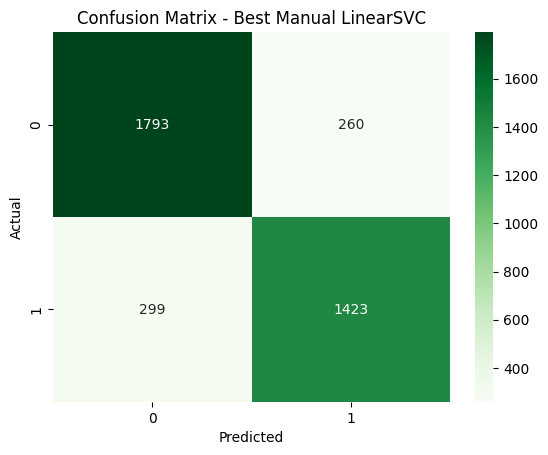

In [38]:
# Select best manual model by Accuracy
best_manual_idx = np.argmax([r['Accuracy'] for r in results_manual])
best_manual_params = results_manual[best_manual_idx]['Parameters']

best_manual_model = LinearSVC(max_iter=5000, **best_manual_params, random_state=42)
best_manual_model.fit(X_train_scaled, y_train)
y_pred_manual = best_manual_model.predict(X_test_scaled)
y_scores_manual = best_manual_model.decision_function(X_test_scaled)

metrics_manual = [
    accuracy_score(y_test, y_pred_manual),
    f1_score(y_test, y_pred_manual),
    precision_score(y_test, y_pred_manual),
    recall_score(y_test, y_pred_manual),
    roc_auc_score(y_test, y_scores_manual)
]

cm_manual = confusion_matrix(y_test, y_pred_manual)
sns.heatmap(cm_manual, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Best Manual LinearSVC")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



=== GRIDSEARCHCV SVM ===

✅ Best Parameters (GridSearchCV): {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
✅ Test Accuracy: 0.9409


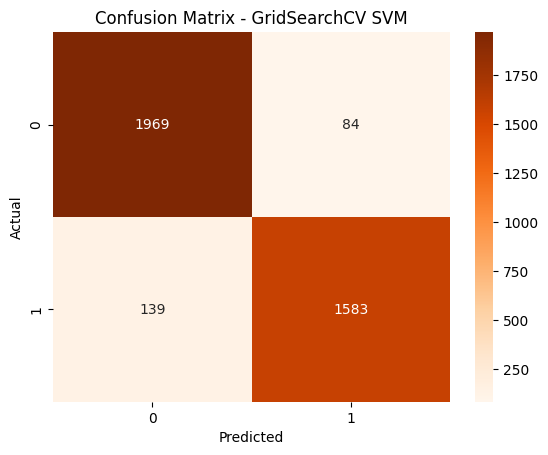

In [37]:
# 4. GridSearchCV SVM
# -------------------------
print("\n=== GRIDSEARCHCV SVM ===")
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 0.1]
}

grid_search = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train_scaled, y_train)

best_grid_model = grid_search.best_estimator_
y_pred_grid = best_grid_model.predict(X_test_scaled)
y_proba_grid = best_grid_model.predict_proba(X_test_scaled)[:, 1]

metrics_best = [
    accuracy_score(y_test, y_pred_grid),
    f1_score(y_test, y_pred_grid),
    precision_score(y_test, y_pred_grid),
    recall_score(y_test, y_pred_grid),
    roc_auc_score(y_test, y_proba_grid)
]

print("\n✅ Best Parameters (GridSearchCV):", grid_search.best_params_)
print(f"✅ Test Accuracy: {metrics_best[0]:.4f}")

cm_grid = confusion_matrix(y_test, y_pred_grid)
sns.heatmap(cm_grid, annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - GridSearchCV SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [39]:
# 5. Comparison Table
# -------------------------
results = pd.DataFrame({
    'Model Variety': ['Default SVM', 'Manual LinearSVC', 'GridSearchCV SVM'],
    'Accuracy': [metrics_default[0], metrics_manual[0], metrics_best[0]],
    'F1 Score': [metrics_default[1], metrics_manual[1], metrics_best[1]],
    'Precision': [metrics_default[2], metrics_manual[2], metrics_best[2]],
    'Recall': [metrics_default[3], metrics_manual[3], metrics_best[3]],
    'AUC': [metrics_default[4], metrics_manual[4], metrics_best[4]],
})

print("\n==== Model Comparison Table ====")
print(results)


==== Model Comparison Table ====
      Model Variety  Accuracy  F1 Score  Precision    Recall       AUC
0       Default SVM  0.938278  0.931772   0.939752  0.923926  0.981104
1  Manual LinearSVC  0.851921  0.835830   0.845514  0.826365  0.911935
2  GridSearchCV SVM  0.940927  0.934199   0.949610  0.919280  0.983783
